<a href="https://colab.research.google.com/github/VanessaMMH/EDA-B/blob/main/EDA_kdtree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Implementacion de KD-Tree

In [74]:
import math
import numpy as np

class kdTree_node:
    
    def __init__(self, x, y, split_along_x=True):
        self.x = x
        self.y = y
        self.xmax = math.inf
        self.ymax = math.inf
        self.xmin = -math.inf
        self.ymin = -math.inf
        self.split_along_x = split_along_x
        self.left = None
        self.right = None
        
    def __str__(self):
        return "(x="+str(self.x)+",y="+str(self.y)+")"



class kdTree:
    def __init__(self, xs, ys):
        
        i_x_sort = np.argsort(xs)
        i_y_sort = np.argsort(ys)
        self.root = self.__buildTree(xs, ys, i_x_sort, i_y_sort, True)
        
    def print(self):
        self.__printSubtree(self.root)
        
    def __printSubtree(self, node):
        if node.left!=None:
            self.__printSubtree(node.left)
        print(node)
        if node.right!=None:
            self.__printSubtree(node.right)
    
    def __select(self, isorted, isecond):
        iy = np.array([]).astype(int)
        for i in isecond:
            r = (isorted==i)
            if r.any()==True:
                iy=np.append(iy,i)
        return iy
    
    def __buildTree(self, xs, ys, ix, iy, splitx=None, father=None):
        l = ix.shape[0]
        med = l//2
        
        # Split along the xaxis
        if splitx:
            n = kdTree_node(xs[ix[med]], ys[ix[med]], True)
            if father != None:
                
                n.xmin = father.xmin
                n.xmax = father.xmax
                n.ymin = father.ymin
                n.ymax = father.ymax
                
                if n.y <= father.y:
                    n.ymax = father.y
                    
                else:
                    n.ymin = father.y 
                    
            if med > 0:
                sub_iy = self.__select(ix[:med],iy)
                n.left = self.__buildTree(xs, ys, ix[:med], sub_iy, False, n)
            if med+1<l:
                sub_iy = self.__select(ix[med+1:], iy)
                n.right = self.__buildTree(xs, ys, ix[med+1:], sub_iy, False, n)
            
        # This node corresponds to a split of the data along y
        else:

            n = kdTree_node(xs[iy[med]], ys[iy[med]], False)
            if father != None:

                n.xmin = father.xmin
                n.xmax = father.xmax
                n.ymin = father.ymin
                n.ymax = father.ymax

                if n.x < father.x:
                    n.xmax = father.x

                else:
                    n.xmin = father.x

            if med > 0:
                sub_ix = self.__select(iy[:med],ix)
                n.left = self.__buildTree(xs, ys, sub_ix, iy[:med], True, n)
            if med+1<l:
                sub_ix = self.__select(iy[med+1:], ix)
                n.right = self.__buildTree(xs, ys, sub_ix, iy[med+1:], True, n)

        return n 
    
    def is_fully_contained(self, node, r):
        if node:
            if r['xmin'] <= node.xmin and r['xmax'] >= node.xmax and r['ymin'] <= node.ymin and r['ymax'] >= node.ymax:
                return True
        return False
    
    def is_intersect(self, node, r):
        if node:
            if r['ymin'] > node.ymax or r['ymax'] < node.ymin or r['xmin'] > node.xmax or r['xmax'] < node.xmin:
                return False
        return True
    
    def range_search(self, node, r):
       
        results = []
        if node == None:
            return results
        if node.left == None and node.right == None:
            
            if r['xmin'] <= node.x and r['xmax'] >= node.x and r['ymin'] <= node.y and r['ymax'] >= node.y:
                results.append(node)
         
        else:
            if r['xmin'] <= node.x and r['xmax'] >= node.x and r['ymin'] <= node.y and r['ymax'] >= node.y:
                results.append(node)
                
            if self.is_fully_contained(node.left, r):
                results += self.traverse(node.left)
            
            elif self.is_intersect(node.left, r):
                results += self.range_search(node.left, r)
            
            if self.is_fully_contained(node.right, r):
                results += self.traverse(node.right)
                
            elif self.is_intersect(node.right, r):
                results += self.range_search(node.right, r)
               
        return results

    def traverse(self, node):
        members = []
        if node:
            members += self.traverse(node.left)
            members.append(node)
            members += self.traverse(node.right)
        return members

In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Importando el archivo covid.xlsx

In [33]:
import pandas as pd
import numpy as np
file_loc = "/content/drive/MyDrive/EDA/covid_kaggle.xlsx"
df = pd.read_excel(file_loc, index_col=None, na_values=['NA'], usecols="B,C,G,I,J,M,N,O,Q,S,AP")
df.head(10)


,Patient age quantile,SARS-Cov-2 exam result,Hematocrit,Platelets,PlateletVolume,MCHC,Leukocytes,Basophils,Eosinophils,Monocytes,Proteina C reativa mg/dL
0,13,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,17,negative,0.236515,-0.517413,0.010677,-0.950790,-0.09461,-0.223767,1.482158,0.357547,-0.147895
2,8,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,15,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,9,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,13,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,16,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1,negative,-1.571682,1.429667,-1.672222,3.331071,0.36455,-0.223767,1.018625,0.068652,-0.286986
9,17,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
df = df.rename( columns = {'Patient age quantile':'Patient',
                            'SARS-Cov-2 exam result':'SARS-Cov-2',
                            'Proteina C reativa mg/dL':'Proteina_C'}) # Modificar el nombre de un índice individualmente

df.head(10)

,Patient,SARS-Cov-2,Hematocrit,Platelets,PlateletVolume,MCHC,Leukocytes,Basophils,Eosinophils,Monocytes,Proteina_C
0,13,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,17,negative,0.236515,-0.517413,0.010677,-0.950790,-0.09461,-0.223767,1.482158,0.357547,-0.147895
2,8,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,15,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,9,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,13,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,16,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1,negative,-1.571682,1.429667,-1.672222,3.331071,0.36455,-0.223767,1.018625,0.068652,-0.286986
9,17,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#Modificando columna SARS-cov

In [35]:
df['SARS-Cov-2'] = df['SARS-Cov-2'].replace('negative', 0)
df['SARS-Cov-2'] = df['SARS-Cov-2'].replace('positive', 1)
df

,Patient,SARS-Cov-2,Hematocrit,Platelets,PlateletVolume,MCHC,Leukocytes,Basophils,Eosinophils,Monocytes,Proteina_C
0,13,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,17,0,0.236515,-0.517413,0.010677,-0.950790,-0.094610,-0.223767,1.482158,0.357547,-0.147895
2,8,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,15,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
5639,3,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5640,17,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5641,4,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5642,10,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
df.iloc[:,:].describe()

,Patient,SARS-Cov-2,Hematocrit,Platelets,PlateletVolume,MCHC,Leukocytes,Basophils,Eosinophils,Monocytes,Proteina_C
count,5644.000000,5644.000000,6.030000e+02,6.020000e+02,5.990000e+02,6.020000e+02,6.020000e+02,6.020000e+02,6.020000e+02,6.010000e+02,5.060000e+02
mean,9.318391,0.098866,-2.186214e-09,-3.535004e-10,7.438143e-09,1.014863e-09,6.215833e-09,-6.633739e-09,7.206147e-09,-3.220114e-09,2.779703e-09
std,5.777903,0.298509,1.000830e+00,1.000832e+00,1.000836e+00,1.000832e+00,1.000832e+00,1.000832e+00,1.000832e+00,1.000833e+00,1.000990e+00
min,0.000000,0.000000,-4.501420e+00,-2.552426e+00,-2.457575e+00,-5.431808e+00,-2.020303e+00,-1.140144e+00,-8.355077e-01,-2.163721e+00,-5.353622e-01
25%,4.000000,0.000000,-5.188074e-01,-6.053457e-01,-6.624832e-01,-5.524761e-01,-6.372547e-01,-5.292256e-01,-6.669502e-01,-6.141920e-01,-5.135051e-01
50%,9.000000,0.000000,5.340703e-02,-1.217160e-01,-1.015171e-01,-5.458523e-02,-2.128790e-01,-2.237665e-01,-3.298351e-01,-1.151911e-01,-3.942844e-01
75%,14.000000,0.000000,7.171751e-01,5.314981e-01,6.838353e-01,6.424628e-01,4.542955e-01,3.871516e-01,3.443949e-01,4.888627e-01,3.242637e-02
max,19.000000,1.000000,2.662704e+00,9.532034e+00,3.713052e+00,3.331071e+00,4.522042e+00,1.107822e+01,8.350876e+00,4.533397e+00,8.026671e+00


In [44]:
df2 = df.dropna()


In [45]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
ss=StandardScaler()
X_cols=["Patient","SARS-Cov-2","Hematocrit","Platelets","PlateletVolume ","MCHC","Leukocytes","Basophils","Eosinophils","Monocytes","Proteina_C"]
df2[X_cols]=ss.fit_transform(df2[X_cols])
df2.head(10)

,Patient,SARS-Cov-2,Hematocrit,Platelets,PlateletVolume,MCHC,Leukocytes,Basophils,Eosinophils,Monocytes,Proteina_C
1,0.987910,-0.393818,0.221449,-0.500902,0.045080,-0.982771,-0.131293,-0.173930,1.464169,0.387537,-0.148168
8,-1.822020,-0.393818,-1.548568,1.405048,-1.659050,3.394003,0.311576,-0.173930,1.007946,0.095140,-0.286536
18,-0.065814,-0.393818,0.960823,0.077031,-0.522963,-0.473844,-0.244023,-0.791658,-0.692521,-0.197258,-0.486181
28,0.285427,-0.393818,0.983227,-0.168898,0.840340,-0.372056,-0.112504,2.605850,0.219925,0.095140,-0.432810
29,0.461048,-0.393818,0.714365,0.359850,-0.522963,0.645799,0.061959,-0.482794,-0.360723,0.148303,-0.527691
30,-0.417055,-0.393818,-0.674762,0.937783,-0.863790,-0.270272,-0.316492,-0.173930,-0.526622,0.839424,0.541694
34,0.987910,-0.393818,0.781581,-0.267269,1.635600,1.052938,-0.040035,0.443799,0.054025,-0.489655,-0.359673
36,0.461048,-0.393818,-0.114630,1.405048,-0.182139,-0.982771,0.660502,0.134935,-0.526622,0.095140,-0.517807
38,0.812289,-0.393818,1.386523,0.593482,-1.091007,-0.372056,-0.061507,0.752664,-0.360723,-0.489655,-0.413043
40,0.636669,-0.393818,0.691959,0.396739,0.726731,-0.270272,-0.211814,0.443799,-0.153349,0.626772,-0.353743


In [49]:
pca2=PCA(n_components=2,random_state=42)
pca_2=pca2.fit_transform(df2[X_cols])
pca_2[:5]

array([[-0.55880284,  0.84930716],
       [ 1.87733692,  0.90879821],
       [ 0.1862188 , -0.08976528],
       [-1.3850036 ,  1.64537291],
       [ 0.08005302,  0.09877128]])

In [72]:
#df_pca=pd.DataFrame({'PCA1':pca_2[:,0],'PCA2':pca_2[:1],'Class':df2['Class']})
df_pca= pd.DataFrame (data = pca_2
             , columns = ['PCA1', 'PCA2'])
df_pca.head(5)

,PCA1,PCA2
0,-0.558803,0.849307
1,1.877337,0.908798
2,0.186219,-0.089765
3,-1.385004,1.645373
4,0.080053,0.098771


#Representación del árbol kd

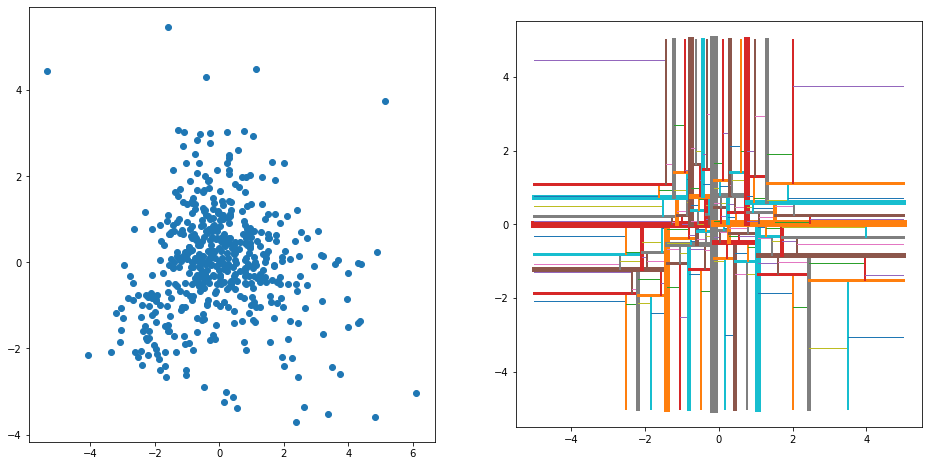

In [76]:
import pandas as pd
import geopandas as gpd
import numpy as np
import math
import matplotlib.pyplot as plt

def drawSubtree(node,s, ax):
    if node.left!=None:
        drawSubtree(node.left,s+1, ax)
        # Draw the current node as a line segment
    width = 8-s
    if node.split_along_x==True:
        if (width>0):
            ax.plot([node.x,node.x],[max(-5,node.ymin),min(node.ymax,5)],linewidth=width)
    else:
        if (width>0):
            ax.plot([max(-5,node.xmin),min(node.xmax,5)],[node.y,node.y],linewidth=width)
    
    if node.right!=None:
        drawSubtree(node.right,s+1, ax)
def draw(kdTree, ax):
    drawSubtree(kdTree.root,0, ax)
if __name__=='__main__':

    kdt = kdTree(pca_2[:,0],pca_2[:,1])
    # Plot the station positions and the number of slots
  
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,8))
    axes[0].scatter(pca_2[:,0],pca_2[:,1])
    plt.gca().set_aspect('equal', adjustable='box')
    draw(kdt, axes[1])
    plt.show()

#Buscar un rango en una región en particular

In [67]:
if __name__=='__main__':

	kdt = kdTree(pca_2[:,0],pca_2[:,1])

	xmin =  int(input("Enter min x: "))
	xmax = int(input("Enter max x: "))
	ymin = int(input("Enter min y: "))
	ymax = int(input("Enter max y: "))

	r = {'xmin':xmin ,'xmax':xmax, 'ymin':ymin, 'ymax': ymax}
	node = kdTree_node(xmax, ymin)
	results = kdt.range_search(kdt.root, r)

	x = [node.x for node in results]
	y = [node.y for node in results]
	
	print(pd.DataFrame({'x':x, 'y':y}))

Enter min x: -1
Enter max x: 1
Enter min y: -1
Enter max y: 1
            x         y
0   -0.645039 -0.539256
1   -0.902720 -0.775629
2   -0.841173 -0.868810
3   -0.830983 -0.775258
4   -0.383354 -0.965071
..        ...       ...
180  0.959318  0.452040
181  0.961945  0.801156
182  0.868094  0.771255
183  0.884293  0.665470
184  0.805313  0.859506

[185 rows x 2 columns]
